# EPR and WEPR Uncertainty Metrics Demonstration

This notebook demonstrates how to use the **Entropy Production Rate (EPR)** and **Weighted Entropy Production Rate (WEPR)** metrics to detect uncertainty and potential hallucinations in LLM outputs.

We will use a set of sample questions, including some that are known to trigger hallucinations, and compare the scores produced by both metrics.

## Setup

First, we import the necessary libraries and the `artefactual` package modules.

In [ ]:
import json
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

# Add src to path to import artefactual modules
sys.path.append("/home/gjeannin/artefactual/src")

from artefactual.data.data_model import Completion
from artefactual.scoring.entropy_methods.epr import EPR
from artefactual.scoring.entropy_methods.wepr import WEPR

/home/gjeannin/artefactual/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-03 18:46:38,092	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 12-03 18:46:39 [__init__.py:216] Automatically detected platform cuda.


2025-12-03 18:46:40.438404: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 18:46:40.450018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-03 18:46:40.464229: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-03 18:46:40.469447: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-03 18:46:40.480012: I tensorflow/core/platform/cpu_feature_guar

## Load Data

We load the sample QA data generated by `Ministral-8B-Instruct-2410`. We will select 5 specific questions:
- 2 factual questions (True)
- 3 questions designed to trigger hallucinations (Hallucination)

In [2]:
# Load the sample data
data_path = Path("/home/gjeannin/artefactual/outputs/sample_qa_data_Ministral-8B-Instruct-2410_entropy.json")
with open(data_path, encoding="utf-8") as f:
    data = json.load(f)

# Select specific questions
# q001: Capital of France (True)
# q002: Author of Romeo and Juliet (True)
# q003_hallucination: Einstein's hair count (Hallucination)
# q004_hallucination: Sherlock Holmes in Paris (Hallucination)
# q005_hallucination: Napoleon's cousin's dog (Hallucination)
selected_ids = ["q001", "q002", "q003_hallucination", "q004_hallucination", "q005_hallucination"]
selected_results = [r for r in data["results"] if r["query_id"] in selected_ids]

## Initialize Scorers

We initialize the `EPR` and `WEPR` scorers using the calibration and weights files for the `Ministral` model.

- **EPR (Entropy Production Rate)**: Measures the rate at which entropy is produced during generation.
- **WEPR (Weighted Entropy Production Rate)**: A weighted version of EPR that learns to emphasize certain uncertainty patterns.

In [3]:
# Paths to calibration and weights files
calibration_file = "/home/gjeannin/artefactual/src/artefactual/data/calibration_Ministral.json"
weights_file = "/home/gjeannin/artefactual/src/artefactual/data/weights_Ministral.json"

# Initialize scorers
epr_scorer = EPR(model=calibration_file)
wepr_scorer = WEPR(model=weights_file)

## Compute Scores

We iterate through the selected questions, convert the raw token log-probabilities into `Completion` objects, and compute the EPR and WEPR scores. Both scores are calibrated to represent the **probability of hallucination** (0 to 1).

In [4]:
results_data = []

for res in selected_results:
    query_id = res["query_id"]
    query = res["query"]
    # Get the first generated answer
    generated_answer = res["generated_answers"][0]["0"]

    # Prepare Completion object
    # The JSON has token_logprobs as a list of dicts, one per generated answer.
    # We take the first one corresponding to our answer.
    token_logprobs_raw = res["token_logprobs"][0]

    # Convert string keys to integers for the Completion model
    token_logprobs = {int(k): v for k, v in token_logprobs_raw.items()}

    completion = Completion(token_logprobs=token_logprobs)

    # Compute scores
    # The compute method returns a list of scores (one per completion passed)
    epr_score = epr_scorer.compute([completion])[0]
    wepr_score = wepr_scorer.compute([completion])[0]

    results_data.append({
        "Query ID": query_id,
        "Query": query,
        "Answer": generated_answer,
        "EPR Score": epr_score,
        "WEPR Score": wepr_score,
        "Type": "Hallucination" if "hallucination" in query_id else "True",
    })

# Create a DataFrame for display
df = pd.DataFrame(results_data)

# Display the dataframe with formatted scores
df_display = df.copy()
df_display["EPR Score"] = df_display["EPR Score"].map("{:.4f}".format)
df_display["WEPR Score"] = df_display["WEPR Score"].map("{:.4f}".format)
display(df_display[["Query ID", "Type", "Answer", "EPR Score", "WEPR Score"]])

,Query ID,Type,Answer,EPR Score,WEPR Score
0,q001,True,Paris,0.4341,0.3351
1,q002,True,William Shakespeare,0.4644,0.3465
2,q003_hallucination,Hallucination,Unknown.,0.8550,0.4332
3,q004_hallucination,Hallucination,1903,0.6320,0.4240
4,q005_hallucination,Hallucination,Toto,0.8958,0.4273


## Visualization

Finally, we visualize the scores. Higher scores indicate a higher probability of hallucination (uncertainty). We expect the "Hallucination" type questions to have significantly higher scores than the "True" questions.

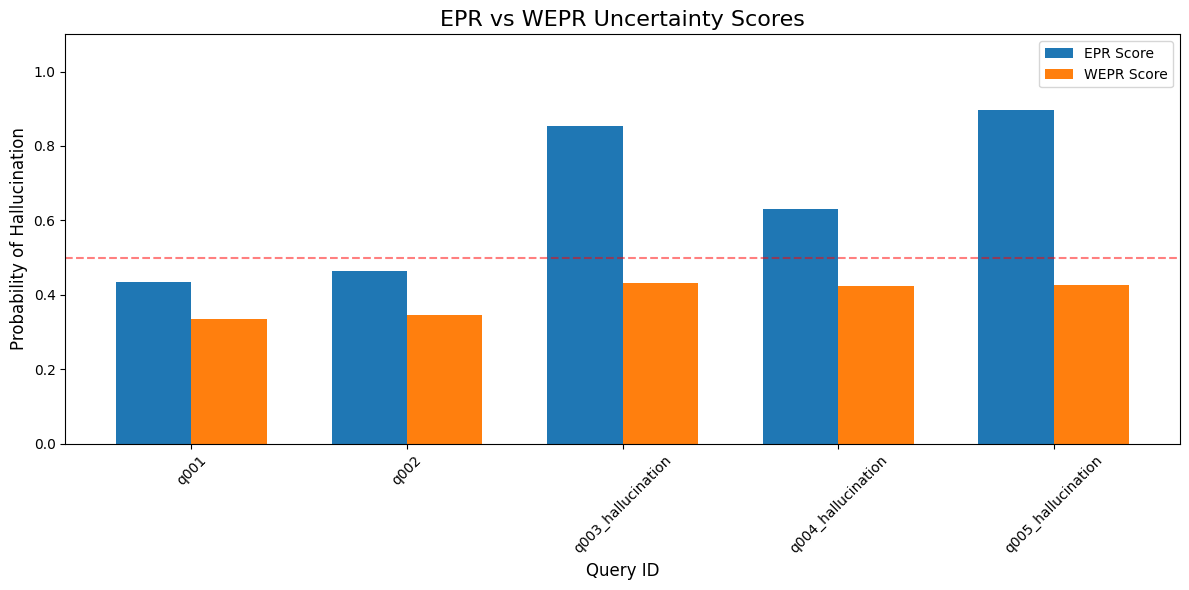

In [5]:
import numpy as np

# Plotting
plt.figure(figsize=(12, 6))

# Data for plotting
query_ids = df["Query ID"]
x = np.arange(len(query_ids))
width = 0.35

# Create bars
plt.bar(x - width / 2, df["EPR Score"], width, label="EPR Score", color="#1f77b4")
plt.bar(x + width / 2, df["WEPR Score"], width, label="WEPR Score", color="#ff7f0e")

# Customization
plt.title("EPR vs WEPR Uncertainty Scores", fontsize=16)
plt.xlabel("Query ID", fontsize=12)
plt.ylabel("Probability of Hallucination", fontsize=12)
plt.xticks(x, query_ids, rotation=45)
plt.ylim(0, 1.1)
plt.legend()

# Add a threshold line
plt.axhline(y=0.5, color="r", linestyle="--", alpha=0.5, label="Threshold (0.5)")

plt.tight_layout()
plt.show()

## Per-Token EPR Analysis

We can also analyze the EPR score contribution for each token in a generated sequence. This helps identify which parts of the response are contributing most to the uncertainty.

Note: For EPR, the per-token scores returned are the raw entropy production rates (uncalibrated), whereas the sequence-level score is calibrated to a probability.

Analyzing Query: What was the name of Napoleon's third cousin's pet dog?
Generated Answer: Toto


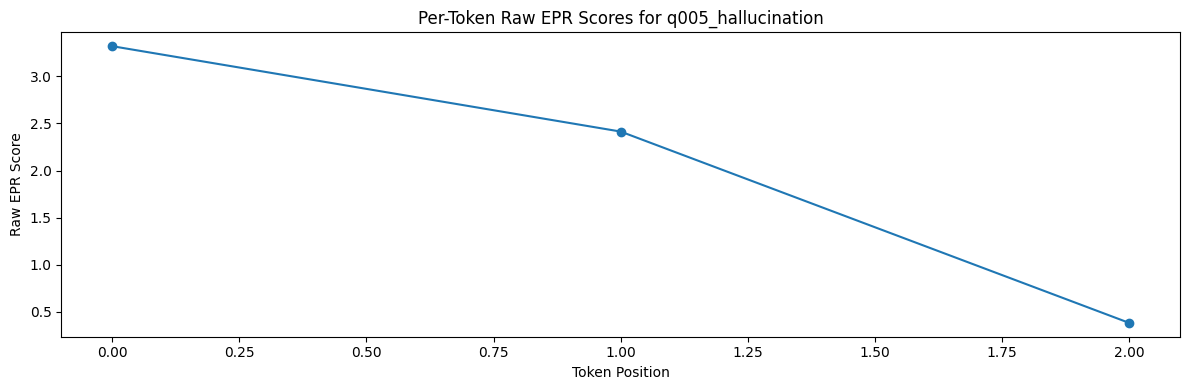

In [6]:
# Select a specific example (e.g., the Einstein hair question which is a hallucination)
query_id_to_analyze = "q005_hallucination"
res = next(r for r in selected_results if r["query_id"] == query_id_to_analyze)


# Prepare completion
token_logprobs_raw = res["token_logprobs"][0]
token_logprobs = {int(k): v for k, v in token_logprobs_raw.items()}
completion = Completion(token_logprobs=token_logprobs)

# Compute per-token EPR scores
# We set return_per_token_scores=True to get the detailed breakdown
seq_scores, token_scores_list = epr_scorer.compute([completion], return_per_token_scores=True)
token_scores = token_scores_list[0]

# Plotting
plt.figure(figsize=(12, 4))
plt.plot(token_scores, marker="o", linestyle="-", color="#1f77b4")
plt.title(f"Per-Token Raw EPR Scores for {query_id_to_analyze}")
plt.xlabel("Token Position")
plt.ylabel("Raw EPR Score")
plt.tight_layout()
plt.show()